# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks using PyTorch
<br>

#### Activity 2a: Implementing a FC for ASL Dataset using PyTorch
<br>


- Objective

    The primary aim of this activity is to transition from using Numpy for network implementation to utilizing PyTorch, a powerful deep learning framework. You will be replicating the work you did for the ASL dataset in Activity 1b, but this time, you'll implement a your multi layer FC model using PyTorch.
    
- Instructions

    Review Previous Work: Begin by reviewing your Numpy-based Fully Connected Network for the ASL dataset from Activity 1b. Note the architecture, hyperparameters, and performance metrics for comparison.

    Introduce PyTorch: If you're new to PyTorch, take some time to familiarize yourself with its basic operations and syntax. You can consult the official documentation or follow online tutorials.

    Prepare the ASL Dataset: As before, download and preprocess the Kaggle ASL dataset. 

    Implement the Network: Design your network architecture tailored for the ASL dataset. Pay special attention to PyTorch modules like nn.Linear() and nn.ReLU().

    Train the Model: Implement the training loop, making use of PyTorch's autograd to handle backpropagation. Monitor metrics like loss and accuracy as the model trains.

    Analyze and Document: In Markdown cells, discuss the architecture choices, any differences in performance between the Numpy and PyTorch implementations, and insights gained from using a deep learning framework like PyTorch.

In [9]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

#PyTorch stuff
import torch
import torch.nn as nn
import torch.nn.functional as F

# Solamente para usuarios de Jupyter Themes
from jupyterthemes import jtplot
jtplot.style(grid=False)

In [10]:
# DATA_PATH = '/media/pepe/DataUbuntu/Databases/asl_data/'
#DATA_PATH = '/home/pepe/Documents/github_repos/datasets/asl_data'
#train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
#valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

#Local version
DATA_PATH = './asl_data'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

### Always a good idea to explore the data

In [11]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Get training label data

In [12]:
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
del train_df['label']
del valid_df['label']
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

In [13]:
print(x_train.shape)
print(y_train.shape)

(27455, 784)
(27455,)


In [14]:
print(x_val.shape, y_val.shape)

(7172, 784) (7172,)


In [15]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    assert x.shape[0] == y.shape[0], 'Number of samples x!= number samples y'
    total_samples = x.shape[0]
    if shuffle:
        idxs = np.arange(x.shape[0])
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
        #return x_val, y_val, x_test, y_test
#         return x[:total_samples//2, :], y[:total_samples//2], x[total_samples//2:, :], y[total_samples//2:]
    return x[:int(total_samples*pct), :], y[:int(total_samples*pct)], x[int(total_samples*(pct)):, :], y[int(total_samples*(pct)):]
        

In [16]:
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

In [17]:
type(y_val)

numpy.ndarray

In [18]:
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(3586, 784) (3586,)
(3586, 784) (3586,)


In [19]:
alphabet=list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

24


### Normalise the data

In [20]:
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [21]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)


In [22]:
x_train.mean(), x_train.std()

(3.6268384e-06, 0.99999946)

In [23]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

In [24]:
type(x_val)

numpy.ndarray

La imagen muestreada representa un: c


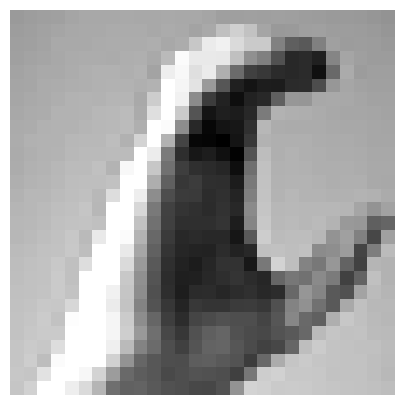

In [25]:
rnd_idx = np.random.randint(len(y_val))
# print(rnd_idx)
# print(y_val[rnd_idx])
print(f'La imagen muestreada representa un: {alphabet[y_val[rnd_idx]]}')
plot_number(x_val[rnd_idx].reshape(28,28))

### The model

$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Create minibatches

In [26]:
def create_minibatches(mb_size, x, y, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
        
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

In [27]:
for i, (x, y) in enumerate(create_minibatches(128,x_train, y_train)):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214


### Now the PyTorch part

In [28]:
x_train_tensor = torch.tensor(x_train.copy())
y_train_tensor = torch.tensor(y_train.copy())

x_val_tensor = torch.tensor(x_val.copy())
y_val_tensor = torch.tensor(y_val.copy())

x_test_tensor = torch.tensor(x_test.copy())
y_test_tensor = torch.tensor(y_test.copy())

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


### Accuracy

In [30]:
def accuracy(model, x, y, mb_size):
    num_correct = 0
    num_total = 0
    cost = 0.
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for mb, (xi, yi) in enumerate(create_minibatches(mb_size, x, y),1):
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            cost += (F.cross_entropy(scores, yi)).item()
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)

        return cost/mb, float(num_correct)/num_total  

### Training Loop

In [31]:
def train(model, optimiser, mb_size, epochs=100):
    model = model.to(device=device)
    train_cost = 0.
    val_cost = 0.
    for epoch in range(epochs):
        train_correct_num  = 0.
        train_total = 0.
        train_cost_acum = 0
        for mb, (xi, yi) in enumerate(create_minibatches(mb_size, x_train_tensor, y_train_tensor), 1):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            # funcion cost
            cost = F.cross_entropy(input= scores, target=yi.squeeze())
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
            
            train_correct_num += (torch.argmax(scores, dim=1) == yi.squeeze()).sum()
            train_total += scores.size(0)  
            
            train_cost_acum += cost.item()
        
        val_cost, val_acc = accuracy(model, x_val_tensor, y_val_tensor, mb_size)
        train_acc = float(train_correct_num)/train_total
        train_cost = train_cost_acum/mb
        if epoch%20 == 0:            
            print(f'Epoch:{epoch}, train cost: {train_cost:.6f}, val cost: {val_cost:.6f},'
                      f' train acc: {train_acc:.4f}, val acc: {val_acc:4f},'
                      f' lr: {optimiser.param_groups[0]["lr"]:.6f}')
    

### Model using Sequential

In [32]:
#Instanciar modelo
# hidden1 = 100 
hidden = 200
lr = 1e-3
epochs = 100
mb_size = 128
model1 = nn.Sequential(nn.Linear(in_features=784, out_features=hidden), 
                       nn.Dropout(),
                       nn.ReLU(),
#                        nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=24))
# optimiser = torch.optim.SGD(model1.parameters(), lr=lr, momentum=0.9, weight_decay=1e-2)
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser, 0.1, epochs=epochs, steps_per_epoch=215)

train(model1, optimiser, mb_size, epochs)

Epoch:0, train cost: 0.853010, val cost: 0.824268, train acc: 0.7289, val acc: 0.753765, lr: 0.004000
Epoch:20, train cost: 0.197950, val cost: 1.818403, train acc: 0.9580, val acc: 0.790853, lr: 0.004000
Epoch:40, train cost: 0.243045, val cost: 2.522959, train acc: 0.9573, val acc: 0.788344, lr: 0.004000
Epoch:60, train cost: 0.178432, val cost: 2.692716, train acc: 0.9640, val acc: 0.770496, lr: 0.004000
Epoch:80, train cost: 0.183940, val cost: 2.466466, train acc: 0.9653, val acc: 0.786113, lr: 0.004000


In [33]:
accuracy(model1, x_test_tensor, y_test_tensor, mb_size)[1]

0.8011712214166202

In [34]:
def predict(x, model):
    x = x.to(device=device, dtype = torch.float32)
    scores = model(x) # mb_size, 10
    _, pred = scores.max(dim=1) #pred shape (mb_size )
    return pred

La imagen muestreada representa un: x


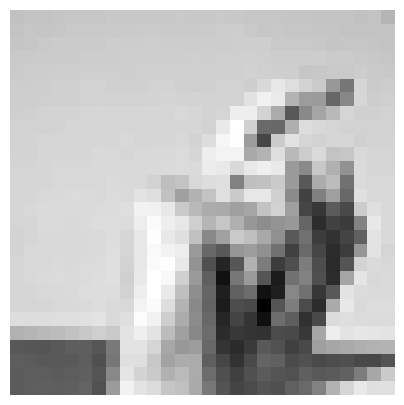

el valor predicho x


In [35]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {alphabet[y_test[rnd_idx]]}')
plot_number(x_test[rnd_idx].reshape(28,28))
pred=predict(x_test_tensor[rnd_idx].reshape(1, -1), model1)
print(f'el valor predicho {alphabet[pred]}')